In [10]:
import serial
import numpy as np

In [8]:
class MBP:
    def __init__(self, COM_port):
        self.ser = serial.Serial('COM1', 9600, parity=serial.PARITY_NONE, stopbits = 1,
                    xonxoff = 0, timeout = 0.5, bytesize = 8)
        
    def read(self):
        stop = b'\rD >'
        ret = b''
        while True:
            b = self.ser.read(1)
            if b == b'\r':
                self.ser.read(3)
                break
            else:
                ret += b
        return ret.decode()

    def command(self, command):
        self.ser.write(str.encode(command+'\r'))
        return self.read()
    
    def GetModel(self):
        return self.command("GETMODEL")
    
    def LaserState(self, laser = 0):
        return self.command(f"LASERSTATE {laser}")
    
    def Power(self, point = 3):
        return self.command(f"POWER {point}")
    
    def GetLDEnable(self):
        return self.command('getLDenable')
    
    def GetPower(self, point = 0):
        return self.command(f'GETPOWER {point}')
    
    def GetMode(self):
        return self.command('GETMODE')
    
    def GetState(self):
        return self.command('GETSTATE')
    
    def GetOut(self):
        return self.command('GETOUT')
    
    def GetLaserState(self):
        return self.command('GETLASERSTATE')

    def GetLaserStateSym(self, value = 0):
        """
        Returns the strings corresponding to the laserstate integer returns.
        Note that param value does not correspond to the integer returned by
        GetLaserState, need to loop through value 0 to 17 to get all
        corresponding codes.
        E.g. 0 -> OFF
             6 -> KEYLOCK
             7 -> INTERLOCK
        """
        return self.command(f'GETLASERSTATESYM {value}')

    def GetPowerEnable(self):
        return self.command('GETPOWERENABLE')
    
    def GetFault(self):
        """
        Get faults, returns 5 bits
        1   SHG temperature
        2   TEC temperature
        3   Laser diode current
        4   Watchdog timeout
        5   Case temperature
        """
        return self.command('GETFLT')

    def GetAlarm(self):
        """
        Get alarms, returns 5 bits
        1   SHG temperature
        2   TEC temperature
        3   Pump bias
        4   Loss of output
        5   Case temperature
        """
        return self.command('GETALR')
    
    def SetEnv(self, env = 0):
        return self.command(f'SETENV {env}')
    
    def EnterTestEnvironment(self):
        return self.command('testeoa')+self.read()+self.read()
    
    def SetSHGTemperature(self, temperature = 50.7):
        return self.command(f'SETTECSETPT 4 {temperature}')

    def GetSHGSetpoint(self):
        return self.command('GETTECSETPT 4')
    
    def SetLDEnable(self, on = 0):
        """
        Enabling the MBP amplifier
        """
        return self.command(f'setLDenable {on}')

    def GetLDCurrent(self, ld = 0):
        """
        Returns the LD {ld} current setpoint
        """
        return self.command(f'GETLDCURRENT {ld}')

    def SetLDCurrent(self, ld = 3, current = 1000):
        """
        Set the LD {ld} current setpoint
        """
        return self.command(f'SETLDCURRENT {ld} {current}')

    def LDCurrent(self, ld = 3):
        """
        Returns the actual LD {ld} current
        """
        return self.command(f'LDCURRENT {ld}')

    def PowerEnable(self, enable = 0):
        """
        Set the amplifier to ACC or APC mode
        0   ACC
        1   APC
        """
        return self.command(f'POWERENABLE {enable}')
    
    def GetSHGTemperature(self):
        return self.command('TECTEMP 4')

## Testing MBP Amp functions

In [98]:
mbp = MBP('COM1')
for f in [func for func in dir(mbp) if (callable(getattr(mbp, func)) & ('__' not in func) & (func not in ['command', 'read']))]:
    print(f'{f:20}:', getattr(mbp, f)())
mbp.ser.close()

EnterTestEnvironment: TEST ENVIRONMENTy knowledgeable personnel should use test commands.sure to observe all pertinent safety precautions.
GetAlarm            : 0 0 0 0 0 0
GetFault            : 0 0 0 0 0
GetLDCurrent        : RS232.C 1 UNKNOWN_COMMAND
GetLDEnable         : 0
GetLaserState       : 0
GetLaserStateSym    : 0 OFF
GetMode             : 1
GetModel            : 2RU-VYFL-P-1000-543.5-SF-FRCPC
GetOut              : 0 0 0 1
GetPower            : 600
GetPowerEnable      : 1
GetSHGSetpoint      : 50.7
GetState            : 1
LDCurrent           : 0
LaserState          : CMD.C 11 INACTIVE_LD#_(A.1)
Power               : 9.1609
PowerEnable         : 
SetEnv              : 
SetLDCurrent        : RS232.C 1 UNKNOWN_COMMAND
SetSHGTemperature   : RS232.C 7 CAN_ONLY_BE_USED_FOR_TESTS
setLDEnable         : 


## SHG Temperature Scan for power optimization

In [174]:
import numpy as np
import time
power_in = []
power_out = []
temp_SHG = []
ld3_current = []

temp = np.arange(50.5, 50.95, 0.03)

mbp = MBP('COM1')
mbp.EnterTestEnvironment()
mbp.SetLDEnable(1)
time.sleep(20)

for idt, t in enumerate(temp):
    mbp.SetSHGTemperature(t)
    print(f'{mbp.GetSHGSetpoint()}: {idt+1}/{len(temp)}')
    time.sleep(15)
    pintmp =[]
    pouttmp = []
    shgtemptmp = []
    ld3tmp = []
    for _ in range(10):
        pintmp.append(mbp.Power(3))
        pouttmp.append(mbp.Power(0))
        shgtemptmp.append(mbp.GetSHGTemperature())
        ld3tmp.append(mbp.LDCurrent(3))
        time.sleep(0.1)
    power_in.append(pintmp)
    power_out.append(pouttmp)
    temp_SHG.append(shgtemptmp)
    ld3_current.append(ld3tmp)
    time.sleep(1)

mbp.SetLDEnable(0)
mbp.ser.close()

50.5: 1/16
50.53: 2/16
50.56: 3/16
50.59: 4/16
50.62: 5/16
50.65: 6/16
50.68: 7/16
50.71: 8/16
50.74: 9/16
50.77: 10/16
50.8: 11/16
50.83: 12/16
50.86: 13/16
50.89: 14/16
50.92: 15/16
50.95: 16/16


In [395]:
data_type = np.dtype([('SHG temperature setpoint', np.float), ('seed power', np.float), ('output power', np.float), ('SHG temperature measured', np.float), ('LD3 current', np.float)])

with h5py.File('mbp_communications_measurements.hdf5', 'w') as f:
    data = np.array([np.repeat(temp, 10), np.array(power_in).flatten(), np.array(power_out).flatten(), np.array(temp_SHG).flatten(), np.array(ld3_current).flatten()]).T
    data = np.array([tuple(d) for d in data], dtype = data_type)
    dset = f.create_dataset('SHG_temperature_scan', data = data)
    dset.attrs['description'] = "Measurement of MBP Communications 2RU-VYFA-SF Series amplifier output power as a function of SHG temperature"
    dset.attrs['seed'] = 'NKT Photonics Koheras Basic'
    dset.attrs['frequency [GHz]'] = 275844.950
    dset.attrs['units'] = "{'SHG temperature setpoint': 'C', 'seed power': 'mW', 'output power': 'mW', 'SHG temperature measured': 'C', 'LD3 current': 'mA'}"

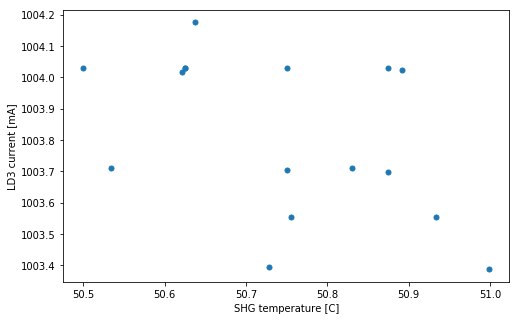

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp_SHG).astype(float).mean(axis = 1), np.array(ld3_current).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature [C]')
ax.set_ylabel('LD3 current [mA]');

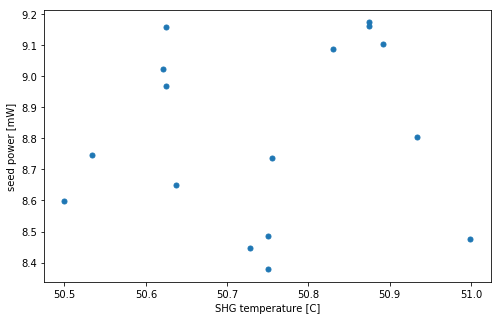

In [199]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp_SHG).astype(float).mean(axis = 1), np.array(power_in).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature [C]')
ax.set_ylabel('seed power [mW]');

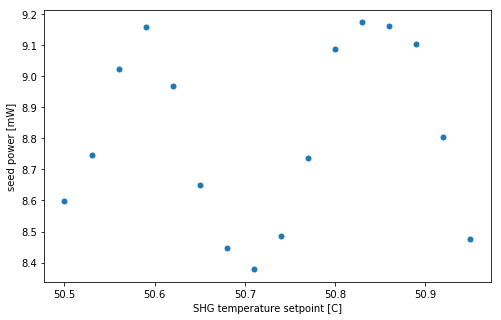

In [207]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(temp, np.array(power_in).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature setpoint [C]')
ax.set_ylabel('seed power [mW]');

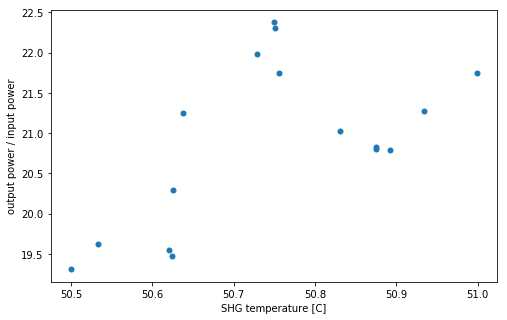

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp_SHG).astype(float).mean(axis = 1), (np.array(power_out).astype(float)/np.array(power_in).astype(float)).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature [C]')
ax.set_ylabel('output power / input power');

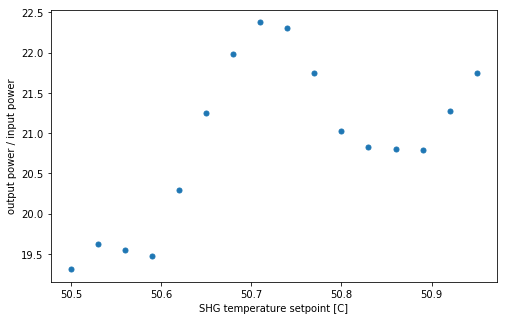

In [204]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp).astype(float), (np.array(power_out).astype(float)/np.array(power_in).astype(float)).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature setpoint [C]')
ax.set_ylabel('output power / input power');

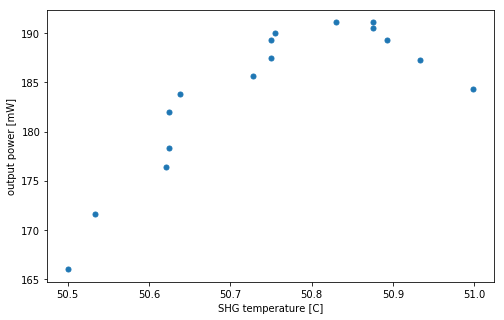

In [201]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp_SHG).astype(float).mean(axis = 1), np.array(power_out).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature [C]')
ax.set_ylabel('output power [mW]');

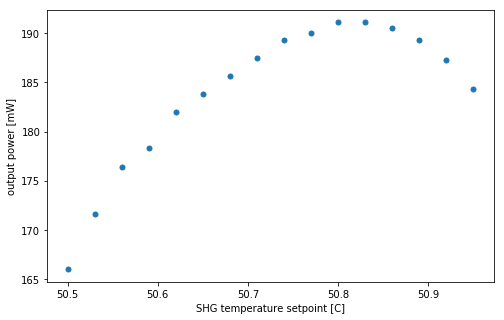

In [205]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(temp, np.array(power_out).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature setpoint [C]')
ax.set_ylabel('output power [mW]');

In [208]:
mbp = MBP('COM1')
mbp.EnterTestEnvironment()
mbp.SetSHGTemperature(50.7)
mbp.ser.close()

## Input power monitoring

In [227]:
import numpy as np
import time

total_time = 60*30
dt = 0.1

mbp = MBP('COM1')


power_in_mon = np.empty(int(total_time/dt))
time_measured = np.empty(int(total_time/dt))

try:
    for _ in range(int(total_time/dt)):
        power_in_mon[_] = float(mbp.Power(3))
        time_measured[_] = time.time()
        time.sleep(dt)
except KeyboardInterrupt:
    mbp.ser.close()

mbp.ser.close()

In [396]:
import h5py

data_type = np.dtype([('time', np.float), ('power', np.float)])

with h5py.File('mbp_communications_measurements.hdf5', 'a') as f:
    data = np.array([time_measured, power_in_mon]).T
    data = np.array([tuple(d) for d in data], dtype = data_type)
    dset = f.create_dataset('seed_power_monitoring', data = data)
    dset.attrs['description'] = "Measurement of MBP Communications 2RU-VYFA-SF Series amplifier input seed power from NKT Photonics Koheras Basik"
    dset.attrs['seed'] = 'NKT Photonics Koheras Basic'
    dset.attrs['frequency [GHz]'] = 275844.950
    dset.attrs['units'] = "{'time': 's', 'power': 'mW'}"

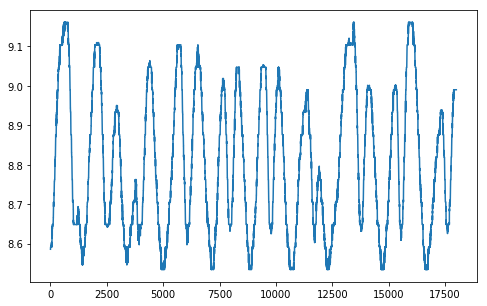

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot((time_measured-time_measured[0])/60, np.array(power_in_mon, dtype = float))
ax.set_xlabel('time [m]')
ax.set_ylabel('[mW]')
ax.set_title('Seed power @MBP Amp')
fig.savefig('seed_power.png', dpi = 300)

In [14]:
import numpy as np
import time

total_time = 60*30
dt = 0.1

mbp = MBP('COM1')


power_in_mon = np.empty(int(total_time/dt))
time_measured = np.empty(int(total_time/dt))

try:
    for _ in range(int(total_time/dt)):
        power_in_mon[_] = float(mbp.Power(3))
        time_measured[_] = time.time()
        time.sleep(dt)
except KeyboardInterrupt:
    mbp.ser.close()

mbp.ser.close()

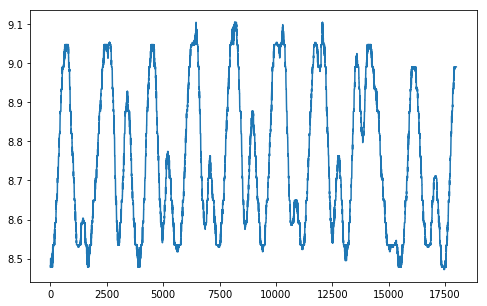

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(power_in_mon[power_in_mon > 5], dtype = float))

In [16]:
import h5py

data_type = np.dtype([('time', np.float), ('power', np.float)])

with h5py.File('mbp_communications_measurements.hdf5', 'a') as f:
    data = np.array([time_measured, power_in_mon]).T
    data = np.array([tuple(d) for d in data], dtype = data_type)
    dset = f.create_dataset('seed_power_monitoring_unlocked', data = data)
    dset.attrs['description'] = "Measurement of MBP Communications 2RU-VYFA-SF Series amplifier input seed power from NKT Photonics Koheras Basik"
    dset.attrs['seed'] = 'NKT Photonics Koheras Basic'
    dset.attrs['frequency [GHz]'] = 275844.950
    dset.attrs['locked'] = False
    dset.attrs['units'] = "{'time': 's', 'power': 'mW'}"

## Check Room Air Temp Correlation

In [2]:
import functools
import numpy as np
import time
import logging
import urllib.request
from urllib.error import URLError, HTTPError
from socket import timeout

def CatchUrllibErrors(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except (URLError, HTTPError, timeout) as err:
            logging.warning('WirelessSensorStationLasertable warning in {0}() : '.format(func.__name__) \
                            +str(err))
            return np.nan
    return wrapper

class WirelessSensorStationLasertable2:
    def __init__(self, time_offset, ip):
        self.time_offset = time_offset
        self.ip = ip
        self.verification_string = self.VerifyOperation()
        if not isinstance(self.verification_string, str):
            self.verification_string = "False"
        self.new_attributes = []
        self.dtype = 'f'
        self.shape = (4,)
        self.warnings = []

    def __enter__(self):
        return self

    def __exit__(self, *exc):
        pass

    def GetWarnings(self):
        return []

    @CatchUrllibErrors
    def VerifyOperation(self):
        with urllib.request.urlopen("http://"+self.ip+"/STATUS", timeout = 1) as response:
            status = response.read().decode()
        return status.split(',')[0]

    @CatchUrllibErrors
    def ReadValue(self):
        with urllib.request.urlopen("http://"+self.ip+"/BME280", timeout = 1) as response:
            value = response.read().decode()
        values = [time.time()-self.time_offset]
        value = [float(v.split(':')[-1].strip()) for v in value.split(',')]
        values.extend(value)
        return values


In [57]:
import numpy as np
import time

total_time = 60*30
dt = 0.1

mbp = MBP('COM1')
wss = WirelessSensorStationLasertable2(time.time(), '172.29.129.233')


power_in_mon = np.empty(int(total_time/dt))
time_measured = np.empty(int(total_time/dt))
temp = np.empty(int(total_time/dt))
hum = np.empty(int(total_time/dt))

try:
    for _ in range(int(total_time/dt)):
        val = wss.ReadValue()
        if isinstance(val, list):
            temp[_] = val[1]
            hum[_] = val[2]
        else:
            temp[_] = np.nan
            hum[_] = np.nan
        power_in_mon[_] = float(mbp.Power(3))
        time_measured[_] = time.time()
        time.sleep(dt)
except KeyboardInterrupt:
    mbp.ser.close()
except Exception as e:
    mbp.ser.close()
    raise e

mbp.ser.close()

In [58]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

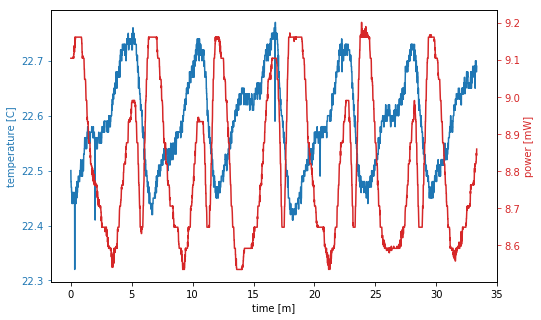

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt

t = np.array(temp, dtype = float)
nans, x= nan_helper(t)
t[nans] = np.interp(x(nans), x(~nans), t[~nans])

h = np.array(hum, dtype = float)
nans, x= nan_helper(h)
h[nans] = np.interp(x(nans), x(~nans), h[~nans])

p = np.array(power_in_mon, dtype = float)

mask = (time_measured - time_measured[0]) < 2000
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(((time_measured-time_measured[0])[mask]/60), t[mask])

ax1 = ax.twinx()
ax1.plot(((time_measured-time_measured[0])[mask]/60), p[mask], 'C3')
ax.set_xlabel('time [m]')
ax.set_ylabel('temperature [C]', color = 'C0')
ax1.set_ylabel('power [mW]', color = 'C3')

ax.tick_params(axis='y', colors='C0')
ax1.tick_params(axis='y', colors='C3')
fig.savefig('temperature_power.png', dpi = 300)

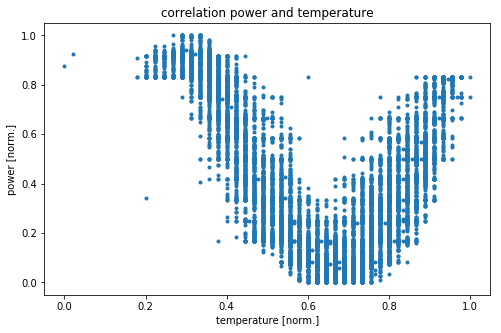

In [118]:
t -= t.min()
t /= t.ptp()

h -= h.min()
h /= h.ptp()

p -= p.min()
p /= p.ptp()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t, p, '.')
ax.set_xlabel('temperature [norm.]')
ax.set_ylabel('power [norm.]')
ax.set_title('correlation power and temperature')
fig.savefig('temp_power_correlation.png', dpi = 300)

In [61]:
import h5py
data_type = np.dtype([('time', np.float), ('power', np.float), ('temperature', np.float), ('humidity', np.float)])

with h5py.File('mbp_communications_measurements.hdf5', 'a') as f:
    data = np.array([time_measured, power_in_mon, temp, hum]).T
    data = np.array([tuple(d) for d in data], dtype = data_type)
    dset = f.create_dataset('seed_power_monitoring_unlocked_temperature', data = data)
    dset.attrs['description'] = "Measurement of MBP Communications 2RU-VYFA-SF Series amplifier input seed power from NKT Photonics Koheras Basik with temperature logging"
    dset.attrs['seed'] = 'NKT Photonics Koheras Basic'
    dset.attrs['frequency [GHz]'] = 275844.950
    dset.attrs['locked'] = False
    dset.attrs['units'] = "{'time': 's', 'power': 'mW', 'temperature': 'C', 'humidity': '%'}"